Connecting to Google Drive for DATA

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep_Learning/Final Project
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Deep_Learning/Final Project
example_test_files/  optiver2023/  public_timeseries_testing_util.py  submission.csv  train.csv


In [ ]:
trainPath= "/content/drive/MyDrive/Deep_Learning/Final Project/train.csv"

Loading the libraries

In [ ]:
import os
from os import system, getpid, walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
import gc
from psutil import Process;
import joblib
from joblib import Parallel, delayed

from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

Function to see how much memory is being currently used

In [ ]:
def checkMemory():
    """
    This function defines the memory usage across the kernel.
    Source-
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    """;
    pid = getpid();
    py = Process(pid);
    memory_use = py.memory_info()[0] / 2. ** 30;
    return f"RAM memory GB usage = {memory_use :.4}";

Distribution of multiple GPU acceleration Stratergy for tensorflow

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of GPU devices: {}'.format(strategy.num_replicas_in_sync))


Number of GPU devices: 1


Defining the hyper parameters

In [ ]:
SEED = 42

N_LAGS =   30 #4#20#55#10 #4 # 2 # define window size(N_Lags + 1)

BATCH_SIZE =   32 #64
BUFFER_SIZE = 100000 # for shuff function
EPOCHS =   100 # 1000 #500
PATIENCE =  15#10#5
DROPOUT = 0.8#0.5
LEARNING_RATE = 1e-4

SPLIT_DAY = 420 #set split day

# STUDY_PERIOD_DAYS = 200 # for evaluation only
# TRAINING_DAYS = 150    # for evaluaton only
# TESTING_DAYS = 50      # for evalution only

N_STOCKS = 200  # define the maximum stock id
N_DATES = 481 # define the maximum stock dates
N_SECONDS = 55  # define the maximum seconds 0- 540 second for each day


RUN_TRAINING = True
RUN_FOR_SUBMISSION = True

os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

Read train data, and calculate how much time it takes. We only take the stock_id, date_id, seconds in bucket and target variable for now

In [ ]:
%%time
# df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df = pd.read_csv(trainPath, engine="pyarrow") # use Multiple thread reading CSV file
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df.shape

CPU times: user 11.5 s, sys: 9.39 s, total: 20.9 s
Wall time: 19.9 s


(5237980, 4)

Reduce memory usage by changing the data types based on maximum range of the variables (colums of dataframes)

In [ ]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB
Memory usage after optimization is: 49.95 MB
Decreased by 68.75%


In [ ]:
checkMemory()

'RAM memory GB usage = 2.17'

In [ ]:
all_stock_ids = range(N_STOCKS)
all_date_ids = range(N_DATES)
all_seconds = [i * 10 for i in range(N_SECONDS)] # since data is avaiable after every 10 seconds

This function creates an multiindex datatype array that has all the different combinantion of variables specified. (here, stock_id, date_id, seconds in bucket)

In [ ]:
multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                         names=['stock_id', 'date_id', 'seconds_in_bucket'])

Now we can reindex our dataframe based on the multi_index array created above (to make sure that we have all the different stock_ids at all date_ids and secconds_in_buckets)

In [ ]:
df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)

Look at the missing values in target variable

In [ ]:
df_full.isna().sum().sort_values(ascending = False)

target    53108
dtype: int64

Fill the missing values with 0 for now

In [ ]:
df_full = df_full.fillna(0) # fill NA (miss value) into 0

In [ ]:
df_full.isna().sum().sort_values(ascending = False)

target    0
dtype: int64

In [ ]:
df_full = df_full.reset_index()  # get the proper 4 columns (stock_id, date_id, seconds_in_buckets, target)

In [ ]:
df_full.head()

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775


In [ ]:
gc.collect()  # Free up memory that is no longer referenced or used


36077

In [ ]:
 #create pivot table
df_pivoted = df_full.pivot_table(
            values='target',       # set each row value is taget
            index=['date_id', 'seconds_in_bucket'], # ste date_id, seconds_in_bucket for index
            columns='stock_id')   # set stock_id  for column

In [ ]:
df_pivoted = df_pivoted.reset_index(drop=True) # remove new date_id, second_in_bucket index
df_pivoted.columns.name = None  # remove column name

In [ ]:
df_pivoted

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-3.029704,-5.519986,-8.389950,-4.010201,-7.349849,6.779432,-2.499819,-1.959801,-5.970001,7.970333,...,6.370544,11.940002,-11.529922,-6.489754,3.999472,-0.690222,-0.810027,-8.440018,-0.510216,0.000000
1,0.389814,-1.620054,-7.460117,-1.040101,-6.719828,7.710457,-4.280210,-8.010268,-0.780225,-0.640154,...,4.210472,2.599955,-15.599728,-1.749992,-9.030104,-1.320243,-3.259778,-4.410148,-1.419783,0.000000
2,4.220009,-6.459951,-6.380081,-2.030134,-0.690222,1.009703,2.930164,-12.069941,-4.119873,-3.250241,...,5.379915,-5.970001,-12.710094,2.160072,-9.999871,5.890131,-0.029802,-6.819963,2.599955,0.000000
3,5.450249,-5.149841,-5.819798,1.130104,-2.589822,-3.089905,0.560284,-6.909966,-1.090169,-6.759763,...,-3.269911,1.300573,-16.660095,4.090071,-9.340048,7.020235,1.549721,1.690388,3.010035,0.000000
4,3.169775,-6.750226,-0.280142,-2.350211,-4.900098,-2.070069,2.199411,-1.209974,-3.100038,-8.199811,...,-2.009869,-0.969768,-9.229779,5.700588,-11.489987,4.500151,-1.350045,-1.929998,4.669428,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,3.999472,2.850294,-4.450083,1.720190,1.939535,-4.569888,-0.630021,-1.729727,-0.680089,3.540516,...,-4.730225,-7.420182,2.959967,-2.359748,-0.650287,3.190041,-1.659989,-0.690222,-2.700090,-7.209778
26451,3.190041,3.169775,-5.559921,4.669428,2.139807,1.679659,-0.360012,-3.240108,2.609491,1.679659,...,-3.340244,-3.479719,1.419783,-1.069903,2.319813,3.770590,-3.039837,-3.299713,-2.070069,-9.750128
26452,-0.169873,5.689859,-5.310178,5.639791,1.660585,2.110004,-1.000166,-4.529953,5.409718,0.350475,...,-1.549721,-1.289845,-0.140071,-1.929998,4.609823,1.449585,-6.319880,-1.999736,-2.239943,3.629923
26453,3.110170,10.650158,-5.239844,5.229712,0.300407,-2.030134,-1.180172,-1.310110,3.240108,0.220537,...,-1.440048,-0.299811,-2.120137,-1.350045,3.110170,4.019737,-7.349849,-3.259778,-3.160238,4.760027


In [ ]:
gc.collect()

0

Tensorflow pipeline windowed dataset without shuffle

In [ ]:
def windowed_dataset(series, window_size=N_LAGS, batch_size=BATCH_SIZE):
#     series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Tensorflow pipeline windowed dataset with shuffle

In [ ]:
def windowed_dataset_shuffle(dataset, shuffle=True):
#     dataset = tf.expand_dims(dataset, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

LSTM model

In [ ]:
def build_model(dropout=DROPOUT):
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=True))
    model.add(LSTM(5, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)) # for new version tensorflow
    return model

In [ ]:
with strategy.scope():
    model1 = build_model()
model1.summary()
# result = get_flops_model(model1)
# print("\n\rResult:", result, " GFLOPS")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_16 (LSTM)              (None, 30, 25)            22600     
                                                                 
 lstm_17 (LSTM)              (None, 5)                 620       
                                                                 
 dropout_10 (Dropout)        (None, 5)                 0         
                                                                 
 dense_11 (Dense)            (None, 200)               1200      
                                                                 
Total params: 24420 (95.39 KB)
Trainable params: 24420 (95.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def build_model2(dropout=DROPOUT):
    # must add return sequence=True for multiple level LSTM
    model = tf.keras.models.Sequential([

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu',
                                                        return_sequences=True), input_shape=(N_LAGS, N_STOCKS)), #, return_sequences=True),
    tf.keras.layers.LSTM(64, activation='relu'),
    #         tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(N_STOCKS, activation = 'linear')
    ])
    model.compile(
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), # for new version tensorflow
                       loss="mae", metrics=["mae"])
    return model

In [ ]:
with strategy.scope():
    model2 = build_model2()
model2.summary()
# result = get_flops_model(model2)
# print("\n\rResult:", result, " GFLOPS")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 30, 256)           336896    
 onal)                                                           
                                                                 
 lstm_19 (LSTM)              (None, 64)                82176     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 200)               13000     
                                                                 
Total params: 432072 (1.65 MB)
Trainable params: 432072 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def build_model3(dropout=DROPOUT):
    # must add return sequence=True for multiple level LSTM
    model = tf.keras.models.Sequential([

#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
#                                   input_shape=(N_LAGS, N_STOCKS)),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True,
                                  input_shape=(N_LAGS, N_STOCKS)),
    tf.keras.layers.LSTM(64, activation='relu'),
        #         tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(N_STOCKS, activation = 'linear')
    ])
    model.compile(
#                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), # for new version tensorflow
                       loss="mae", metrics=["mae"])
    return model

In [ ]:
with strategy.scope():
    model3 = build_model3()
model3.summary()
# result = get_flops_model(model2)
# print("\n\rResult:", result, " GFLOPS")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 30, 64)            67840     
                                                                 
 lstm_21 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 200)               13000     
                                                                 
Total params: 113864 (444.78 KB)
Trainable params: 113864 (444.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the BLSTM model
def build_model4(dropout=DROPOUT):
    model = Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(N_LAGS, N_STOCKS)))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation = 'relu'))),
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    model.compile(optimizer='adam', loss='mae')
    return model

In [ ]:
with strategy.scope():
    model4 = build_model4()
model4.summary()
# result = get_flops_model(model2)
# print("\n\rResult:", result, " GFLOPS")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 30, 128)           135680    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 32)            4128      
 stributed)                                                      
                                                                 
 dense_15 (Dense)            (None, 30, 1)             33        
                                                                 
Total params: 139841 (546.25 KB)
Trainable params: 139841 (546.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
split = df_full['date_id'] > SPLIT_DAY
df_train = df_full[~split]
df_valid = df_full[split]


In [ ]:
df_valid

,stock_id,date_id,seconds_in_bucket,target
23155,0,421,0,2.779961
23156,0,421,10,4.869699
23157,0,421,20,6.250143
23158,0,421,30,7.139444
23159,0,421,40,8.139610
...,...,...,...,...
5290995,199,480,500,-7.209778
5290996,199,480,510,-9.750128
5290997,199,480,520,3.629923
5290998,199,480,530,4.760027


In [ ]:
split = df_full['date_id'] > SPLIT_DAY


In [ ]:
df_train

,stock_id,date_id,seconds_in_bucket,target
0,0,0,0,-3.029704
1,0,0,10,0.389814
2,0,0,20,4.220009
3,0,0,30,5.450249
4,0,0,40,3.169775
...,...,...,...,...
5287695,199,420,500,10.080338
5287696,199,420,510,5.470514
5287697,199,420,520,6.339550
5287698,199,420,530,0.950098


Epoch 1/100
723/723 [==============================] - 143s 193ms/step - loss: 0.7237 - mae: 0.7237 - val_loss: 0.6563 - val_mae: 0.6563
Epoch 2/100
723/723 [==============================] - 145s 200ms/step - loss: 0.7197 - mae: 0.7197 - val_loss: 0.6562 - val_mae: 0.6562
Epoch 3/100
723/723 [==============================] - 138s 190ms/step - loss: 0.7195 - mae: 0.7195 - val_loss: 0.6559 - val_mae: 0.6559
Epoch 4/100
723/723 [==============================] - 139s 192ms/step - loss: 0.7191 - mae: 0.7191 - val_loss: 0.6550 - val_mae: 0.6550
Epoch 5/100
723/723 [==============================] - 140s 193ms/step - loss: 0.7174 - mae: 0.7174 - val_loss: 0.6522 - val_mae: 0.6522
Epoch 6/100
723/723 [==============================] - 133s 184ms/step - loss: 0.7319 - mae: 0.7319 - val_loss: 0.6498 - val_mae: 0.6498
Epoch 7/100
723/723 [==============================] - 132s 183ms/step - loss: 0.7117 - mae: 0.7117 - val_loss: 0.6477 - val_mae: 0.6477
Epoch 8/100
723/723 [====================

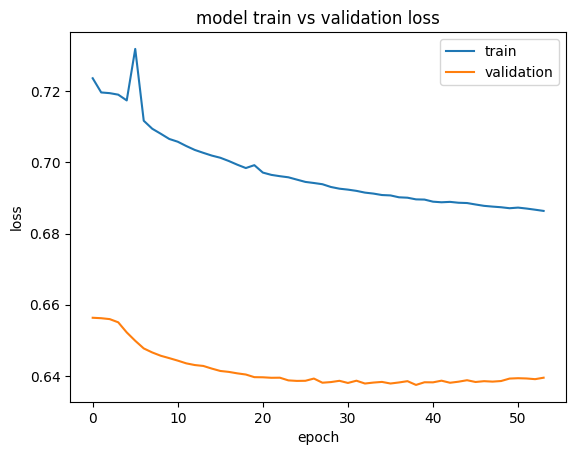

CPU times: user 2h 44min 45s, sys: 7min 41s, total: 2h 52min 26s
Wall time: 2h 5min 12s


In [ ]:
%%time
if RUN_TRAINING:
    # split data
    df_train = df_pivoted[:(SPLIT_DAY+1)*N_SECONDS]
    df_valid = df_pivoted[(SPLIT_DAY+1)*N_SECONDS:]

    scaler = StandardScaler()
    train_features = scaler.fit_transform(df_train)
    valid_features = scaler.transform(df_valid)

    train_dataset = windowed_dataset(train_features)
    valid_dataset = windowed_dataset(valid_features)

    with strategy.scope(): # multiple GPU
        model = build_model2()

    early_stopping = EarlyStopping(monitor='val_loss',
                      mode='min',
                      patience=PATIENCE,
                      restore_best_weights=True,
                      verbose=True)

    history = model.fit(train_dataset,
                        validation_data=valid_dataset,
#                         validation_split=0.1,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stopping],
                        verbose=True)

    ## Evaluate ##
    y_pred = model.predict(valid_dataset)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = df_valid[N_LAGS:]

    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE score: {mae}")

    ## Plots ##
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
def build_features(df):
    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique() # find unqiue date id
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    # Set multi-index (stock_id, date_id, seconds_in_bucket)
    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df_full = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df_full = df_full.fillna(0) # fill missing value with 0
    df_full = df_full.reset_index()

    #create pivot table
    df_pivoted = df_full.pivot_table(
                values='target',       # set each row value is taget
                index=['date_id', 'seconds_in_bucket'], # ste date_id, seconds_in_bucket for index
                columns='stock_id')   # set stock_id  for column

    df_pivoted = df_pivoted.reset_index(drop=True) # remove new date_id, second_in_bucket index
    df_pivoted.columns.name = None  # remove column name

    return df_pivoted

In [ ]:
if RUN_FOR_SUBMISSION:

    import optiver2023
    optiver2023.make_env.func_dict['__called__'] = False
    env = optiver2023.make_env()
    iter_test = env.iter_test()

    counter = 0

    for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test):

        # if test.currently_scored.iloc[0]== False:
        #     sample_prediction['target'] = 0
        #     env.predict(sample_prediction)
        #     counter += 1
        #     continue

        if test.seconds_in_bucket.unique()[0] == 0:

            df_revealed_targets = revealed_targets[["stock_id", "revealed_date_id", "seconds_in_bucket", "revealed_target"]]
            df_revealed_targets = df_revealed_targets.rename(columns={'revealed_date_id': 'date_id', 'revealed_target': 'target'})

            df_features = build_features(df_revealed_targets)

            history_scaled = scaler.transform(df_features)

        y_pred_scaled = model.predict(
            history_scaled[-N_LAGS:][np.newaxis, :, :],
            verbose=True)

        y_pred = scaler.inverse_transform(y_pred_scaled)

        sample_prediction['target'] = y_pred[0]
        env.predict(sample_prediction)
        counter += 1

        history_scaled = np.concatenate([history_scaled, y_pred_scaled])

else:
    print("Run for submission skipped")

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 86ms/step


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-170-15f8bae8117b>", line 10, in <cell line: 1>
    for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test):
  File "competition.py", line 60, in iter_test
OSError: [Errno 107] Transport endpoint is not connected: 'submission.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    